In [1]:
import pandas as pd
import os
import numpy as np
import csv
import pytz
import time
from datetime import datetime
from collections import Counter

import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

# A package which could be used to check whether an account is a bot
import botometer

import matplotlib.pyplot as plt

In [23]:
tweet_2017_path_raw = r'XXXX'
tweet_2016_path_raw = r'XXXXX'
desktop = r'XXXXX'
# saving_path = r'F:\CityU\Datasets'
tweet_filtering_path =  r'XXXXX'
bot_check_path =  r'XXXXX'
bot_check_figure_path =  r'XXXXX'


# Hong Kong and Shanghai share the same time zone.
# Hence, we transform the utc time in our dataset into Shanghai time
time_zone_hk = pytz.timezone('Asia/Shanghai')

In [24]:
# pd.set_option('display.precision', 18)

In [25]:
# Set some account information
# For more details, please go to: https://github.com/IUNetSci/botometer-python
mashape_key = "XXXXXX"
twitter_app_auth = {
    'consumer_key': "XXXXXX",
    'consumer_secret': "XXXXXX",
    'access_token': "XXXXXX",
    'access_token_secret': "XXXXXX",
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          mashape_key=mashape_key,
                          **twitter_app_auth)

auth = OAuthHandler("XXXXXX", "XXXXXX")

auth.set_access_token("XXXXXX", "XXXXXX")

api = tweepy.API(auth)

# Construct the API instance
api = tweepy.API(auth)

## 1. Load some functions

In [26]:
# read multiple csv files from a local directory
def read_text_from_multi_csvs(path):
    all_csv_files = os.listdir(path)
    dataframes = []
    for file in all_csv_files:
        dataframe = pd.read_csv(os.path.join(path, file), encoding='latin-1', dtype='str', 
                                quoting=csv.QUOTE_NONNUMERIC)
        dataframes.append(dataframe)
    combined_dataframes = pd.concat(dataframes, sort=True)
    return combined_dataframes

def read_local_csv_file(path, filename):
    dataframe = pd.read_csv(os.path.join(path, filename), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC, dtype='str', 
                            index_col=0)
    return dataframe

# Function used to output a pandas dataframe for each user based on the user account number
def derive_dataframe_for_each_user(df, all_users):
    dataframes = []
    print('Total number of users is {}'.format(len(all_users)))
    count = 1
    for user in all_users:
        if count % 1000 == 0:
            print('The first {} users have been processed'.format(count))
        dataframes.append(df.loc[df['user_id_str']==user])
        count += 1
    print('Done!')
    return dataframes

# Based on the dataframe for each user, compute the time range between his or her first tweet and last tweet
def compute_time_range_for_one_user(df):
    user_id_str = list(df['user_id_str'])[0]
    first_row_time_object = list(df.head(1)['hk_time'])[0]
    end_row_time_object = list(df.tail(1)['hk_time'])[0]
    time_range = end_row_time_object - first_row_time_object
    return (user_id_str, time_range.days)

# Add a new colume named hk_time
def get_hk_time(df):
    changed_time_list = []
    for _, row in df.iterrows():
        time_to_change = datetime.strptime(row['created_at'], '%a %b %d %H:%M:%S %z %Y')
        # get the hk time
        changed_time = time_to_change.astimezone(time_zone_hk)
        changed_time_list.append(changed_time)
    df['hk_time'] = changed_time_list
    return df

# Output 
def number_of_tweet_user(df):
    user_num = len(set(df['user_id_str']))
    tweet_num = df.shape[0]
    print('Total number of tweet is: {}; Total number of user is {}'.format(
        tweet_num, user_num))

In [27]:
def delete_bots_have_same_geoinformation(df, prop_threshold=0.70):
    users = set(list(df['user_id_str']))
    bot_account = []
    for user in users:
        dataframe = df.loc[df['user_id_str']==user]
        lat_counter = Counter(dataframe['lat'])
        lon_counter = Counter(dataframe['lon'])
        decide = (compute_the_highest_proportion_from_counter(lat_counter, prop_threshold)) or (compute_the_highest_proportion_from_counter(lon_counter, prop_threshold))
        # If only one unqiue geoinformation is found and more than 10 tweets are posted, we regard this account as bot
        if decide:
            bot_account.append(user)
        else:
            pass
    print('Done!')
    cleaned_df = df.loc[~df['user_id_str'].isin(bot_account)]
#     cleaned_df.to_pickle(os.path.join(saving_path, file_name))
    return cleaned_df

def compute_the_highest_proportion_from_counter(counter_dict, prop_threshold):
    total_count = sum(counter_dict.values())
    result = False
    for latitude in list(counter_dict.keys()):
        if counter_dict[latitude]/total_count > prop_threshold:
            result = True
            return result
        else:
            pass
    return result

def compute_tweet_num_geo_prop(df):
    user_set = set(df['user_id_str'])
    result_list = []
    for user in user_set:
        user_dataframe = df.loc[df['user_id_str'] == user]
        tweet_num = user_dataframe.shape[0]
        prop_num_lat = max(list(Counter(user_dataframe['lat']).values()))/sum(Counter(user_dataframe['lat']).values())
        prop_num_lon = max(list(Counter(user_dataframe['lon']).values()))/sum(Counter(user_dataframe['lon']).values())
        prop_num = max(prop_num_lat, prop_num_lon)
        result_list.append((tweet_num, prop_num))
    return result_list

In [28]:
def find_unuseful_geoinformation(df):
    wrong_list = []
    for _, row in df.iterrows():
        try:
            float(row['lat'])
        except:
            wrong_list.append(row['lat'])
    return wrong_list

In [29]:
def check_bot(id_str):
    result = bom.check_account(id_str)
    return result['cap']['universal']

In [30]:
# plot cumulative distribution of a list of values
def plot_cumulative(number_list, bin_num, color, title, xlabel, ylabel, saving_path, file_name):
    
    fig, ax = plt.subplots(1,1,figsize=(10,10), dpi=300)
    
    values, base = np.histogram(number_list, bins=bin_num)
    #evaluate the cumulative
    cumulative = np.cumsum(values)
    # plot the cumulative function

    plt.plot(base[:-1], cumulative, c=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.savefig(os.path.join(saving_path, file_name))
    plt.show()

## 2. Read from local files

In [223]:
combined_dataframe_2017 = read_text_from_multi_csvs(tweet_2017_path_raw)

In [224]:
combined_dataframe_2016 = read_text_from_multi_csvs(tweet_2016_path_raw)

In [225]:
combined_dataframe_2017.shape

(1602627, 44)

In [226]:
combined_dataframe_2016.shape

(1281281, 43)

In [227]:
selected_name_list = ['country', 'country_code', 'created_at', 'description',
       'expanded_url', 'favorited', 'favourites_count',
       'followers_count', 'friends_count', 'full_name', 'geo_enabled',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id_str',
       'in_reply_to_user_id_str', 'lang', 'lat', 'listed_count', 'location',
       'lon', 'name', 'place_id', 'place_lat', 'place_lon', 'place_name',
       'place_type', 'protected', 'retweet_count', 'retweeted', 'screen_name',
       'source', 'statuses_count', 'text', 'time_zone', 'truncated', 'url',
       'user_created_at', 'user_id_str', 'user_lang', 'user_url', 'utc_offset',
       'verified']
len(selected_name_list)

42

In [228]:
combined_dataframe_2016 = combined_dataframe_2016[selected_name_list]

In [229]:
combined_dataframe_2017 = combined_dataframe_2017[selected_name_list]

In [230]:
total_dataframe = pd.concat([combined_dataframe_2017, combined_dataframe_2016], sort=True, axis=0)

In [232]:
number_of_tweet_user(total_dataframe)

Total number of tweet is: 2883908; Total number of user is 179022


## 3. Some initial steps

1. Only consider the English and Chinese tweets
2. Remove the verified accounts
3. Only consider the tweets have geoinformation

In [233]:
total_dataframe_zh_en = total_dataframe.loc[total_dataframe['lang'].isin(['zh', 'en'])]
total_dataframe_zh_en.shape

(1703742, 42)

In [234]:
number_of_tweet_user(total_dataframe_zh_en)

Total number of tweet is: 1703742; Total number of user is 133377


In [235]:
total_dataframe_without_verified = total_dataframe_zh_en.loc[total_dataframe_zh_en['verified'].isin(['FALSE'])]
total_dataframe_without_verified.shape

(1648379, 42)

In [236]:
number_of_tweet_user(total_dataframe_without_verified)

Total number of tweet is: 1648379; Total number of user is 131712


In [237]:
total_dataframe_with_geo = total_dataframe_without_verified.dropna(axis=0, subset=['lat'])
total_dataframe_with_geo.shape

(554921, 42)

In [238]:
number_of_tweet_user(total_dataframe_with_geo)

Total number of tweet is: 554921; Total number of user is 60860


## 4. Remove visitors

First, change the time to Hong Kong time

In [239]:
total_dataframe_with_geo_copy = total_dataframe_with_geo.copy()
total_dataframe_with_hk_time = get_hk_time(total_dataframe_with_geo_copy)

In [240]:
%%time
total_dataframe_with_hk_time['year'] = total_dataframe_with_hk_time.apply(lambda row: int(row['hk_time'].year), axis=1)
total_dataframe_with_hk_time['month'] = total_dataframe_with_hk_time.apply(lambda row: int(row['hk_time'].month), axis=1)
total_dataframe_with_hk_time['month_plus_year'] = total_dataframe_with_hk_time.apply(
    lambda row: str(row['year'])+'_'+str(row['month']), axis=1)

In [241]:
total_dataframe_with_hk_time.head(10)[['user_id_str', 'created_at', 'hk_time', 'year', 'month', 'month_plus_year']]

,user_id_str,created_at,hk_time,year,month,month_plus_year
8,29760327,Sat Dec 31 15:29:07 +0000 2016,2016-12-31 23:29:07+08:00,2016,12,2016_12
9,1130930804,Sat Dec 31 15:29:08 +0000 2016,2016-12-31 23:29:08+08:00,2016,12,2016_12
13,74768210,Sat Dec 31 15:30:00 +0000 2016,2016-12-31 23:30:00+08:00,2016,12,2016_12
31,96368749,Sat Dec 31 15:31:32 +0000 2016,2016-12-31 23:31:32+08:00,2016,12,2016_12
33,3018108065,Sat Dec 31 15:31:46 +0000 2016,2016-12-31 23:31:46+08:00,2016,12,2016_12
46,52745573,Sat Dec 31 15:32:46 +0000 2016,2016-12-31 23:32:46+08:00,2016,12,2016_12
51,111903594,Sat Dec 31 15:33:01 +0000 2016,2016-12-31 23:33:01+08:00,2016,12,2016_12
54,96273306,Sat Dec 31 15:33:19 +0000 2016,2016-12-31 23:33:19+08:00,2016,12,2016_12
57,149424044,Sat Dec 31 15:33:37 +0000 2016,2016-12-31 23:33:37+08:00,2016,12,2016_12
61,262445623,Sat Dec 31 15:33:59 +0000 2016,2016-12-31 23:33:59+08:00,2016,12,2016_12


Sort the dataframe based on the ```hk_time``` column

In [242]:
total_dataframe_with_hk_time_sorted = total_dataframe_with_hk_time.sort_values(by='hk_time')

In [243]:
total_dataframe_with_hk_time_sorted.sample(10)[['user_id_str', 'created_at', 'hk_time', 'year', 'month', 'month_plus_year']]

,user_id_str,created_at,hk_time,year,month,month_plus_year
50,149585330,Tue Aug 15 14:11:34 +0000 2017,2017-08-15 22:11:34+08:00,2017,8,2017_8
214,732398699108687872,Wed May 18 02:14:16 +0000 2016,2016-05-18 10:14:16+08:00,2016,5,2016_5
36,789378074,Thu Jun 08 10:10:11 +0000 2017,2017-06-08 18:10:11+08:00,2017,6,2017_6
35,55845103,Wed Jun 15 20:48:26 +0000 2016,2016-06-16 04:48:26+08:00,2016,6,2016_6
210,28814305,Fri Sep 23 13:49:51 +0000 2016,2016-09-23 21:49:51+08:00,2016,9,2016_9
207,240981263,Fri Jun 17 05:02:12 +0000 2016,2016-06-17 13:02:12+08:00,2016,6,2016_6
27,390048445,Mon Jan 16 06:31:24 +0000 2017,2017-01-16 14:31:24+08:00,2017,1,2017_1
228,190875987,Fri Jun 09 06:59:17 +0000 2017,2017-06-09 14:59:17+08:00,2017,6,2017_6
8,774694926135222272,Sun Jan 01 09:30:03 +0000 2017,2017-01-01 17:30:03+08:00,2017,1,2017_1
177,109767776,Fri Dec 29 10:48:19 +0000 2017,2017-12-29 18:48:19+08:00,2017,12,2017_12


In [244]:
len(set(total_dataframe_with_hk_time_sorted['user_id_str']))

60860

Then, we remove the visitors. Here we only consider the people of which the time range between the first tweet and the last tweet is bigger than 7 days

**Note**: we notice that some visitors, such as Japanese, could stay in Hong Kong for 14 days.

In [245]:
all_users = set(total_dataframe_with_hk_time_sorted['user_id_str'])
dataframes = derive_dataframe_for_each_user(total_dataframe_with_hk_time_sorted, all_users)

Total number of users is 60860
The first 1000 users have been processed
The first 2000 users have been processed
The first 3000 users have been processed
The first 4000 users have been processed
The first 5000 users have been processed
The first 6000 users have been processed
The first 7000 users have been processed
The first 8000 users have been processed
The first 9000 users have been processed
The first 10000 users have been processed
The first 11000 users have been processed
The first 12000 users have been processed
The first 13000 users have been processed
The first 14000 users have been processed
The first 15000 users have been processed
The first 16000 users have been processed
The first 17000 users have been processed
The first 18000 users have been processed
The first 19000 users have been processed
The first 20000 users have been processed
The first 21000 users have been processed
The first 22000 users have been processed
The first 23000 users have been processed
The first 24

In [246]:
time_range_list = []

for df in dataframes:
    # Each value in time_range_list contains the user_id_str and the maximum time range betweet the first
    # tweet and the last tweet
    time_range_list.append(compute_time_range_for_one_user(df))

locals = []

for day in time_range_list:
    if day[1] > 7:
        locals.append(day[0])

local_dataframe = total_dataframe_with_hk_time_sorted.loc[total_dataframe_with_hk_time_sorted['user_id_str'].isin(locals)]

In [247]:
number_of_tweet_user(local_dataframe)

Total number of tweet is: 451353; Total number of user is 18752


## 5. Get the dataset for tweet 2016 and tweet 2017 seperately

In [164]:
dataframe_2016 = local_dataframe.loc[local_dataframe['year'] == 2016]
dataframe_2017 = local_dataframe.loc[local_dataframe['year'] == 2017]

# Some geoinformation of rows is not useful enough
wrong_list_2016 = find_unuseful_geoinformation(dataframe_2016)
wrong_list_2017 = find_unuseful_geoinformation(dataframe_2017)

In [165]:
print(wrong_list_2016, wrong_list_2017)

['https://www.instagram.com/p/BFGklyqhaVb/', 'https://www.instagram.com/p/BFGli0tlrVC/'] []


In [166]:
dataframe_2016_cleaned = dataframe_2016.loc[~dataframe_2016['lat'].isin(wrong_list_2016)]

In [167]:
dataframe_2016_cleaned.shape

(184390, 46)

In [193]:
dataframe_2016_cleaned_copy = dataframe_2016_cleaned.copy()
dataframe_2017_copy = dataframe_2017.copy()

In [194]:
dataframe_2016_cleaned_copy[["lat", "lon"]] = dataframe_2016_cleaned_copy[["lat", "lon"]].astype(np.float64)
dataframe_2017_copy[["lat", "lon"]] = dataframe_2017_copy[["lat", "lon"]].astype(np.float64)

In [195]:
dataframe_2017_copy.to_csv(os.path.join(desktop, 'tweet_data_2017.csv'), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)
dataframe_2016_cleaned_copy.to_csv(os.path.join(desktop, 'tweet_data_2016.csv'), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

In [202]:
# check the user_id_str column
# dataframe_2017_check = pd.read_csv(os.path.join(desktop, 'tweet_data_2017.csv'), encoding='utf-8', 
#                                    quoting=csv.QUOTE_NONNUMERIC, dtype='str')
# list(set(dataframe_2017_check['user_id_str']))

### Save the user_id_str list and pass other columns to the ArcMap

In [199]:
dataframe_2016_id = np.array(list(dataframe_2016_cleaned_copy['user_id_str']))
dataframe_2017_id = np.array(list(dataframe_2017_copy['user_id_str']))

In [200]:
np.save(os.path.join(desktop, 'tweet_2016_ids.npy'), dataframe_2016_id)
np.save(os.path.join(desktop, 'tweet_2017_ids.npy'), dataframe_2017_id)

### Load the datasets, which could be used in the following sections

In [9]:
dataframe_2016_cleaned = read_local_csv_file(path=desktop, filename='tweet_data_2016.csv')
dataframe_2017 = read_local_csv_file(path=desktop, filename='tweet_data_2017.csv')

### Save the latitude and longitude information, which could be passed to the ArcMap

In [10]:
dataframe_2016_geoinfo = dataframe_2016_cleaned[['lat', 'lon']]
dataframe_2017_geoinfo = dataframe_2017[['lat', 'lon']]

The ArcMap will shuffle the rows randomly. We should add a column named ```index``` before passing to ArcMap. This could help us keep the order of the dataset

In [11]:
dataframe_2016_geoinfo_copy = dataframe_2016_geoinfo.copy()
dataframe_2016_geoinfo_copy['index'] = list(range(dataframe_2016_geoinfo_copy.shape[0]))

In [12]:
dataframe_2017_geoinfo_copy = dataframe_2017_geoinfo.copy()
dataframe_2017_geoinfo_copy['index'] = list(range(dataframe_2017_geoinfo_copy.shape[0]))

In [13]:
dataframe_2016_geoinfo_copy.to_csv(os.path.join(desktop, 'tweet_2016_geoinfo.csv'), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)
dataframe_2017_geoinfo_copy.to_csv(os.path.join(desktop, 'tweet_2017_geoinfo.csv'), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

In [14]:
dataframe_2017_geoinfo_copy.head(10)

,lat,lon,index
340,22.21628624,114.2487221,0
348,22.28167335,114.1552205,1
355,22.40605926,114.224178,2
363,22.20283915,113.5396544,3
366,22.20777778,114.2605556,4
380,22.29453165,114.1685411,5
400,23.11891092,113.3219467,6
404,22.31307492,114.0438768,7
408,22.32375913,114.1730004,8
416,22.73647885,114.2477163,9


## 6. Use ArcMap to find tweets in Hong Kong

First, we should replace the ```user_id_str``` column with the corresponding saved array. Because the ArcMap automatically transform the type of ```user_id_str``` column from string to numeric, which may lose some digits if the id is too long

Then, we should load the geoinformation recorded in the processed ```dataframe_2016_geoinfo``` and ```dataframe_2017_geoinfo```

Load the processed datasets first

In [15]:
# Load the dataset which contains the geoinformation'
tweet_2016_tpu_geo = read_local_csv_file(path=desktop, filename='tweet_2016_with_tpuinfo.csv')
tweet_2017_tpu_geo = read_local_csv_file(path=desktop, filename='tweet_2017_with_tpuinfo.csv')

Then order the dataset based on the predefined index. The index in ```tweet_2016_tpu_geo``` dataframe is ```user_id_st``` while the index in ```tweet_2017_tpu_geo``` is ```index```.

In [16]:
tweet_2017_tpu_geo.columns

Index(['Field1', 'lat', 'lon', 'index', 'FID_2', 'FID_1_1', 'merge_Nums',
       'SmallTPU'],
      dtype='object')

In [17]:
tweet_2016_tpu_geo[["user_id_st", 'lat', 'lon']] = tweet_2016_tpu_geo[["user_id_st", 'lat', 'lon']].astype(np.float64)
tweet_2017_tpu_geo[["index", 'lat', 'lon']] = tweet_2017_tpu_geo[["index", 'lat', 'lon']].astype(np.float64)

In [18]:
# Then order the data based on the corresponding index
tweet_2016_tpu_geo_copy = tweet_2016_tpu_geo.copy()
tweet_2016_tpu_geo_sorted = tweet_2016_tpu_geo_copy.sort_values(by='user_id_st')
tweet_2017_tpu_geo_copy = tweet_2017_tpu_geo.copy()
tweet_2017_tpu_geo_sorted = tweet_2017_tpu_geo_copy.sort_values(by='index')

**!!! Add the TPU information and the ids to the dataframe!!!**

In [19]:
tweet_2016_tpu = list(tweet_2016_tpu_geo_sorted['SmallTPU'])
tweet_2017_tpu = list(tweet_2017_tpu_geo_sorted['SmallTPU'])
tweet_2016_ids = np.load(os.path.join(desktop, 'tweet_2016_ids.npy'))
tweet_2017_ids = np.load(os.path.join(desktop, 'tweet_2017_ids.npy'))

In [20]:
dataframe_2017['user_id_str'] = tweet_2017_ids
dataframe_2017['SmallTPU'] = tweet_2017_tpu
dataframe_2016_cleaned['user_id_str'] = tweet_2016_ids
dataframe_2016_cleaned['SmallTPU'] = tweet_2016_tpu

In [21]:
dataframe_2017.head(10)[['user_id_str', 'created_at', 'hk_time', 'lat', 'lon', 'SmallTPU']]

,user_id_str,created_at,hk_time,lat,lon,SmallTPU
340,106942703,Sat Dec 31 16:00:03 +0000 2016,2017-01-01 00:00:03+08:00,22.21628624,114.2487221,197
348,2892511442,Sat Dec 31 16:00:10 +0000 2016,2017-01-01 00:00:10+08:00,22.28167335,114.1552205,121 & 122
355,4053994772,Sat Dec 31 16:00:25 +0000 2016,2017-01-01 00:00:25+08:00,22.40605926,114.224178,757
363,14282045,Sat Dec 31 16:00:46 +0000 2016,2017-01-01 00:00:46+08:00,22.20283915,113.5396544,NaN
366,90582376,Sat Dec 31 16:00:55 +0000 2016,2017-01-01 00:00:55+08:00,22.20777778,114.2605556,197
380,1130930804,Sat Dec 31 16:01:50 +0000 2016,2017-01-01 00:01:50+08:00,22.29453165,114.1685411,211
400,306524050,Sat Dec 31 16:02:40 +0000 2016,2017-01-01 00:02:40+08:00,23.11891092,113.3219467,NaN
404,1130930804,Sat Dec 31 16:02:49 +0000 2016,2017-01-01 00:02:49+08:00,22.31307492,114.0438768,971-974
408,67074845,Sat Dec 31 16:02:59 +0000 2016,2017-01-01 00:02:59+08:00,22.32375913,114.1730004,222
416,10065202,Sat Dec 31 16:03:19 +0000 2016,2017-01-01 00:03:19+08:00,22.73647885,114.2477163,NaN


Load the previous unprocessed file. Check the ids and lat, lons

In [22]:
check_2017 = read_local_csv_file(path=desktop, filename='tweet_data_2017.csv')
check_2017.head(10)[['user_id_str', 'created_at', 'hk_time', 'lat', 'lon']]

,user_id_str,created_at,hk_time,lat,lon
340,106942703,Sat Dec 31 16:00:03 +0000 2016,2017-01-01 00:00:03+08:00,22.21628624,114.2487221
348,2892511442,Sat Dec 31 16:00:10 +0000 2016,2017-01-01 00:00:10+08:00,22.28167335,114.1552205
355,4053994772,Sat Dec 31 16:00:25 +0000 2016,2017-01-01 00:00:25+08:00,22.40605926,114.224178
363,14282045,Sat Dec 31 16:00:46 +0000 2016,2017-01-01 00:00:46+08:00,22.20283915,113.5396544
366,90582376,Sat Dec 31 16:00:55 +0000 2016,2017-01-01 00:00:55+08:00,22.20777778,114.2605556
380,1130930804,Sat Dec 31 16:01:50 +0000 2016,2017-01-01 00:01:50+08:00,22.29453165,114.1685411
400,306524050,Sat Dec 31 16:02:40 +0000 2016,2017-01-01 00:02:40+08:00,23.11891092,113.3219467
404,1130930804,Sat Dec 31 16:02:49 +0000 2016,2017-01-01 00:02:49+08:00,22.31307492,114.0438768
408,67074845,Sat Dec 31 16:02:59 +0000 2016,2017-01-01 00:02:59+08:00,22.32375913,114.1730004
416,10065202,Sat Dec 31 16:03:19 +0000 2016,2017-01-01 00:03:19+08:00,22.73647885,114.2477163


### They are matched!

For tweets not posted in Hong Kong, the ```SmallTPU``` column should be nan

In [23]:
tweet_2017_hk = dataframe_2017.dropna(axis=0, subset=['SmallTPU'])
tweet_2016_hk = dataframe_2016_cleaned.dropna(axis=0, subset=['SmallTPU'])

In [24]:
tweet_2017_hk.shape

(192192, 47)

In [25]:
tweet_2016_hk.shape

(136866, 47)

Save the files to the local directory

In [26]:
tweet_2016_hk.to_csv(os.path.join(desktop, 'tweet_2016_hk.csv'), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)
tweet_2017_hk.to_csv(os.path.join(desktop, 'tweet_2017_hk.csv'), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

In [204]:
%%time
total_2016_2017 = pd.concat([tweet_2016_hk, tweet_2017_hk], axis=0)
print(total_2016_2017.shape)

(329058, 47)
Wall time: 202 ms


In [212]:
number_of_tweet_user(total_2016_2017)

Total number of tweet is: 329058; Total number of user is 15974


Draw the cumulative distribution plot showing the number of tweets and geoinformation proportion

In [205]:
%%time
tweet_num_geo_prop_list = compute_tweet_num_geo_prop(total_2016_2017)
print(tweet_num_geo_prop_list[:5])

[(5, 0.2), (2, 0.5), (3, 0.3333333333333333), (24, 0.08333333333333333), (2, 0.5)]
Wall time: 6min 33s


In [206]:
count_list = [value[0] for value in tweet_num_geo_prop_list]
prop_list = [value[1] for value in tweet_num_geo_prop_list]

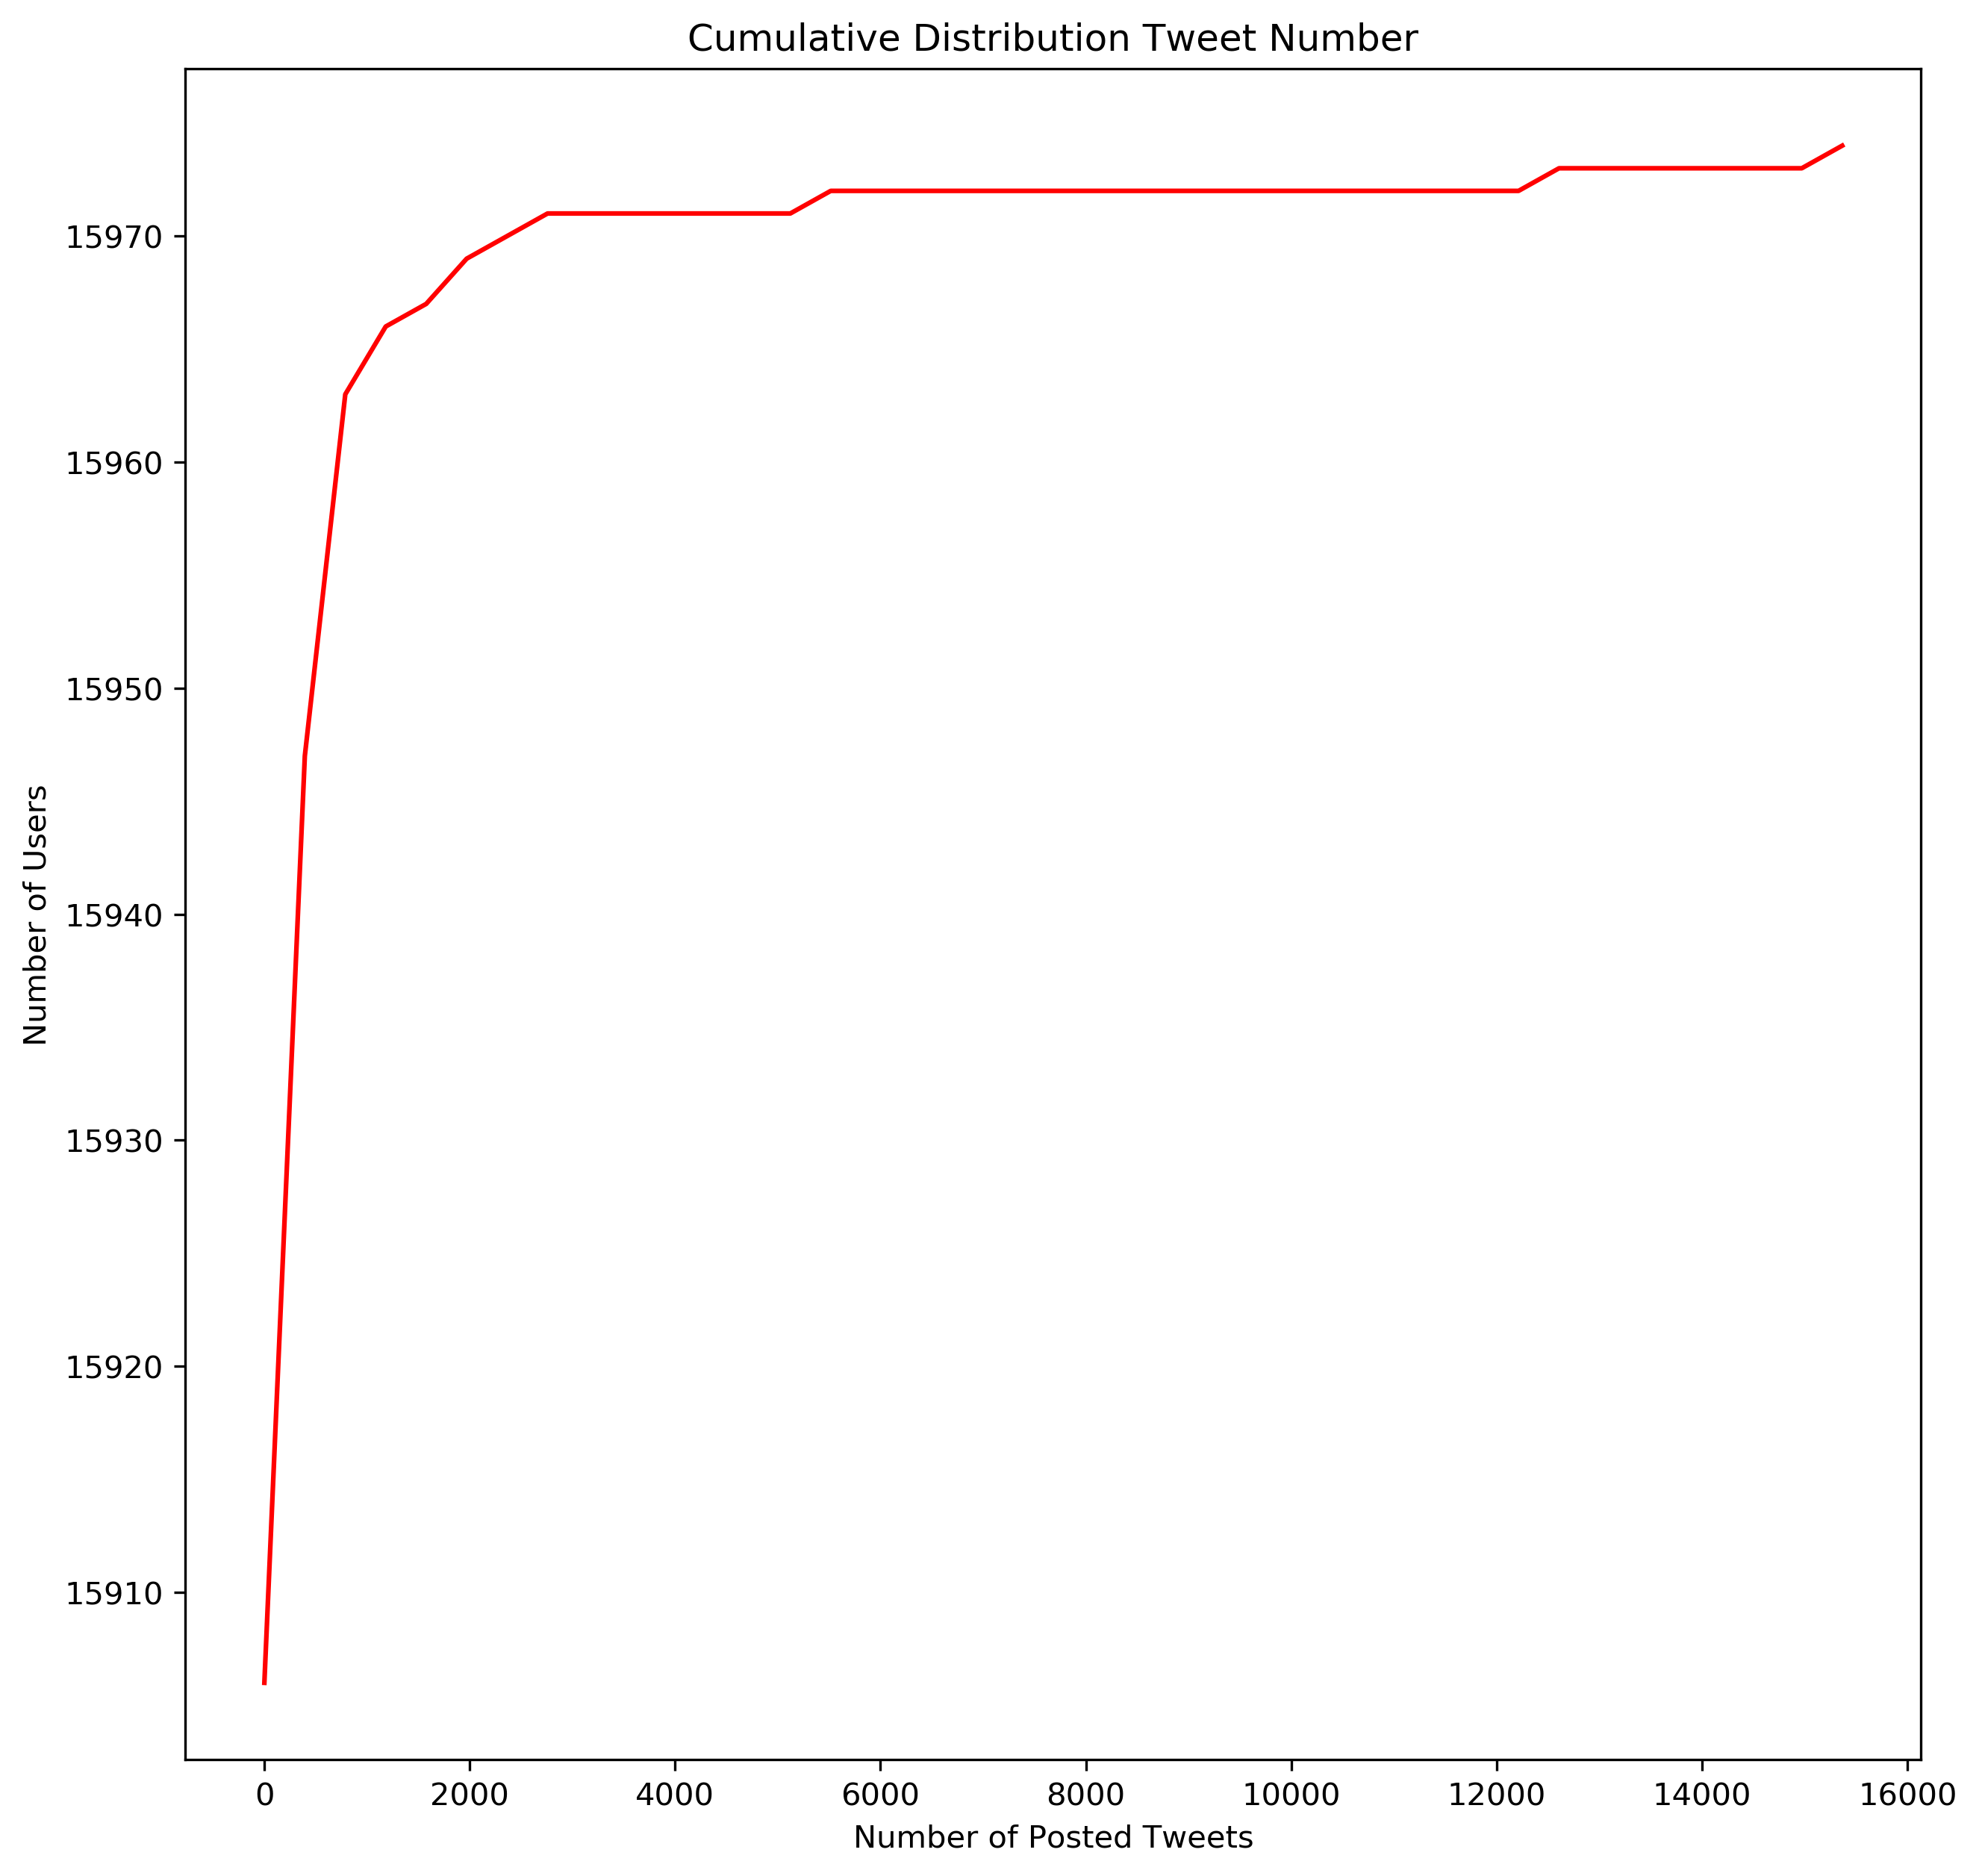

In [220]:
plot_cumulative(number_list=count_list, bin_num=40, color='red', title='Cumulative Distribution Tweet Number', 
                xlabel='Number of Posted Tweets', ylabel='Number of Users', saving_path=bot_check_figure_path, 
                file_name='Cumulative_dist_tweet_num.png')

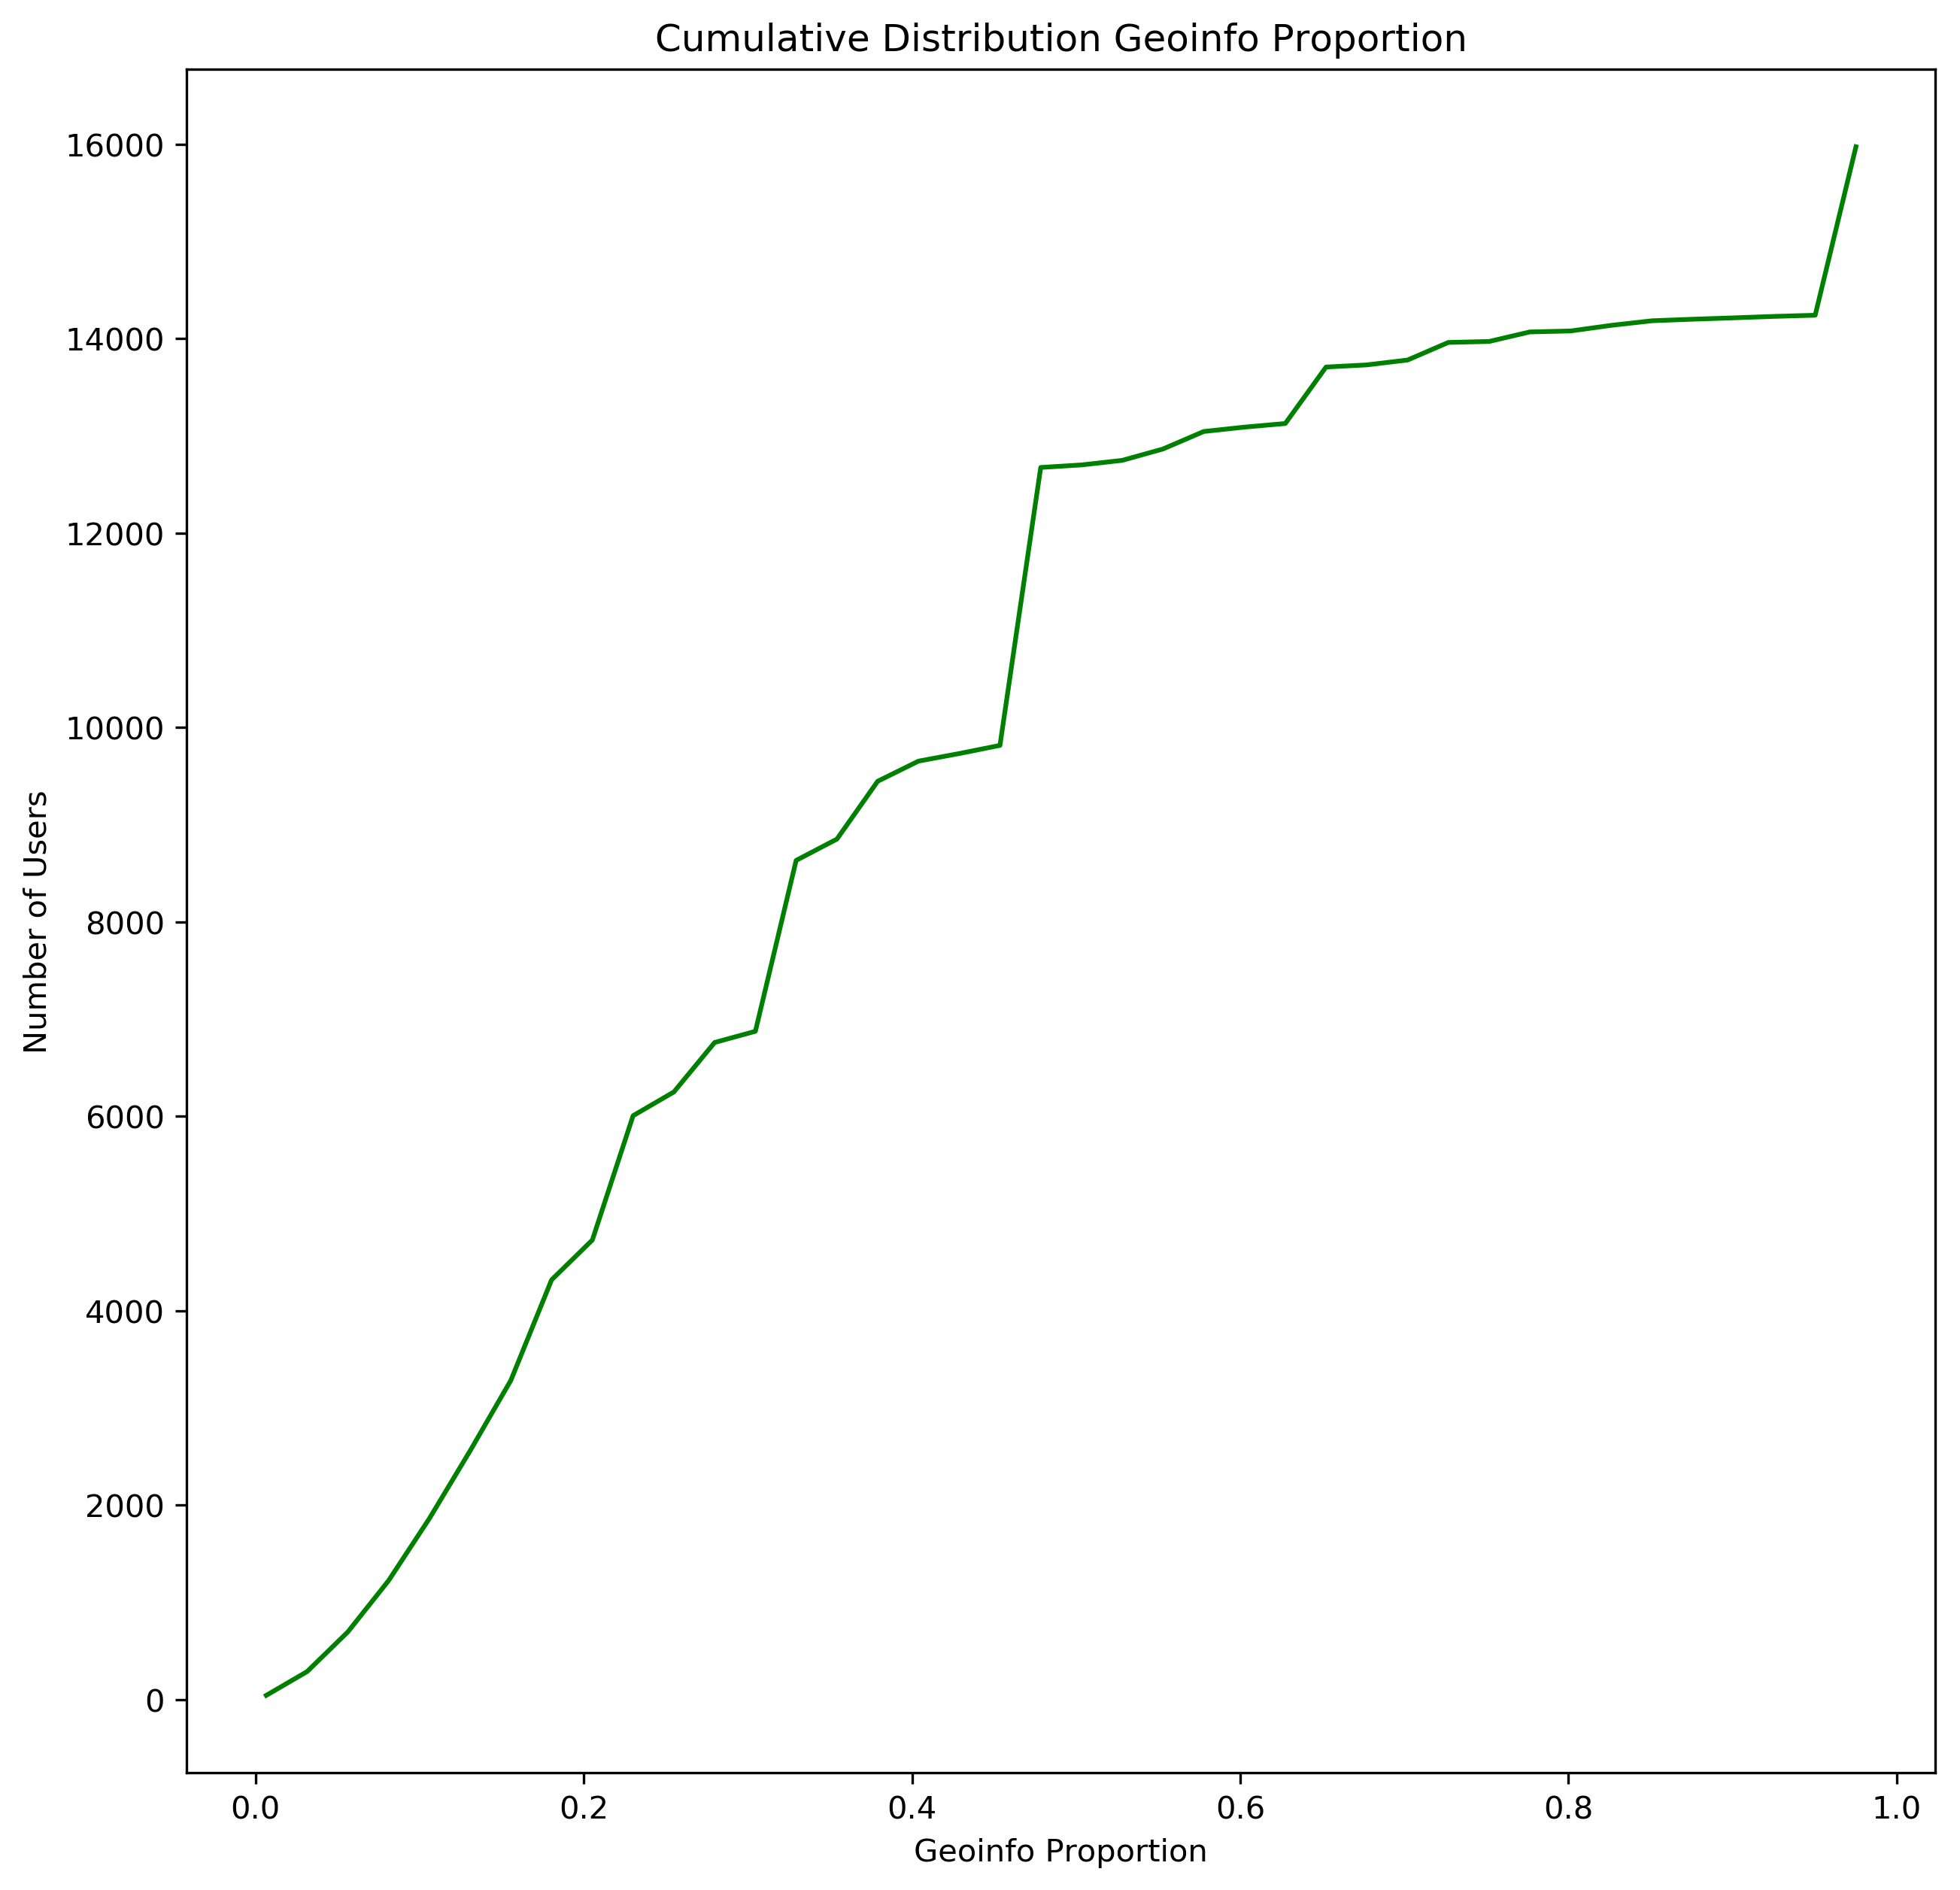

In [221]:
plot_cumulative(number_list=prop_list, bin_num=40, color='green', title='Cumulative Distribution Geoinfo Proportion', 
                xlabel='Geoinfo Proportion', ylabel='Number of Users', saving_path=bot_check_figure_path, 
                file_name='Cumulative_dist_geo_prop.png')

## 7. Delete the bots

**First**, use my own function

In [27]:
tweet_2017_without_bot = delete_bots_have_same_geoinformation(tweet_2017_hk)

Done!


In [28]:
number_of_tweet_user(tweet_2017_without_bot)

Total number of tweet is: 140540; Total number of user is 8604


In [29]:
tweet_2016_without_bot = delete_bots_have_same_geoinformation(tweet_2016_hk)

Done!


In [30]:
number_of_tweet_user(tweet_2016_without_bot)

Total number of tweet is: 117790; Total number of user is 7686


**Second**, use the botometer to filter the tweet

In [159]:
tweet_2017_users_list = list(set(tweet_2017_without_bot['user_id_str']))
tweet_2016_users_list = list(set(tweet_2016_without_bot['user_id_str']))

In [160]:
tweet_all_users = set(tweet_2017_users_list + tweet_2016_users_list)
len(tweet_all_users)

13124

In [117]:
print('Check bots starts....')
bot_result_list = []
processed_account_list = []
account_with_error = []
accounts = list(tweet_all_users)
# The input of the check bot function should be integers
account_integers = [int(number) for number in accounts]
# Get a set of unique users and transform it to list
account_integer_set_list = list(set(account_integers))
account_integer_set_string_list = [str(num) for num in account_integer_set_list]

Check bots starts....


In [82]:
for index, user in enumerate(account_integer_set_list):
    print('-----------------------------------------------')
    print("Coping with the ", index+1, 'th user: ', user)
    try:
        bot_result_list.append(check_bot(int(user)))
        processed_account_list.append(user)
        print('This account could be processed...')
        print('-----------------------------------------------')
    except Exception as e:
        # In this case, the api shows that this page is not authorized or does not exit
        # We record these accouts as Not Authorized in the bot_result_list
        bot_result_list.append('Not Authorized')
        processed_account_list.append(user)
        account_with_error.append(user)
        print('This account has some problem...')
        print('-----------------------------------------------')
    assert len(processed_account_list) == len(bot_result_list)
    if ((index+1) % 1000 == 0):
        print('The first {} users have been processed'.format(index+1))
        print('Have a break!')
        # You **MUST** specify the dtype='str' here  
        check_bot_dataframe = pd.DataFrame({'account':processed_account_list, 'bot_score': bot_result_list}, dtype='str')
        check_bot_dataframe.to_pickle(os.path.join(bot_check_path, 'bot_check_first_{}.pkl'.format(index+1)))
        time.sleep(30) # sleep for 30 seconds
        print('I am OK now!')
    else:
        pass
    
final_bot_likelihood_dataframe = pd.DataFrame({'account':processed_account_list, 'bot_score': bot_result_list}, dtype='str')
final_bot_likelihood_dataframe.to_pickle(os.path.join(bot_check_path, 'final_bot_check.pkl'))

-----------------------------------------------
Coping with the  1 th user:  821611860646592512
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2 th user:  756464839426310145
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3 th user:  792055202039889920
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4 th user:  736792813707231233
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5 th user:  798444796213723136
This account could be processed...
-----------------------------------------------
The first 5 users have been processed
Have a break!
I am OK now!


The computer has shut down! check the unprocessed accounts!

In [108]:
get_processed_dataframe = pd.read_csv(os.path.join(bot_check_path, 'bot_check_first_3000.csv'), encoding='utf-8', dtype='str', 
                                quoting=csv.QUOTE_NONNUMERIC)

In [110]:
get_processed_list = list(get_processed_dataframe['account'])

Get unprocessed list

In [119]:
get_unprocessed_list = list(set(account_integer_set_string_list) - set(get_processed_list))

In [121]:
len(get_unprocessed_list)

10124

In [123]:
print(processed_account_list, bot_result_list, account_with_error)

[] [] []


Use the following codes to check the unprocessed accounts

```Python
print('We still have {} users left'.format(len(get_unprocessed_list)))

for index, user in enumerate(get_unprocessed_list):
    print('-----------------------------------------------')
    print("Coping with the ", index+1, 'th user: ', user)
    try:
        bot_result_list.append(check_bot(int(user)))
        processed_account_list.append(user)
        print('This account could be processed...')
        print('-----------------------------------------------')
    except Exception as e:
        # In this case, the api shows that this page is not authorized or does not exit
        # We record these accouts as Not Authorized in the bot_result_list
        bot_result_list.append('Not Authorized')
        processed_account_list.append(user)
        print('This account has some problem...')
        print('-----------------------------------------------')
    assert len(processed_account_list) == len(bot_result_list)
    if ((index+1) % 1000 == 0):
        print('The first {} users have been processed'.format(index+1))
        print('Have a break!')
        # You **MUST** specify the dtype='str' here  
        check_bot_dataframe = pd.DataFrame({'account':processed_account_list, 'bot_score': bot_result_list}, dtype='str')
        check_bot_dataframe.to_csv(os.path.join(bot_check_path, 'bot_check_second_first_{}.csv'.format(index+1)))
        time.sleep(30) # sleep for 30 seconds
        print('I am OK now!')
    else:
        pass
    
final_bot_likelihood_second_dataframe = pd.DataFrame({'account':processed_account_list, 'bot_score': bot_result_list}, dtype='str')
final_bot_likelihood_second_dataframe.to_csv(os.path.join(bot_check_path, 'final_bot_check.csv'), encoding='utf-8')
```

### Finished! Load all the bot likelihood results

In [129]:
first_bot_file = read_local_csv_file(path=bot_check_path, filename='bot_check_first_3000.csv')
second_bot_file = read_local_csv_file(path=bot_check_path, filename='final_bot_check.csv')

In [134]:
combined_bot_file = pd.concat([first_bot_file, second_bot_file], axis=0)

In [136]:
combined_bot_file.shape

(13124, 2)

In [190]:
combined_bot_file.to_csv(os.path.join(bot_check_path, 'bot_likelihood_2016_2017.csv'), encoding='utf-8')

In [138]:
combined_bot_file.head()

,account,bot_score
0,792055202039889920,0.7086116865750549
1,750147280754409472,0.01645230483113907
2,774891096358780928,0.04861529098537897
3,756464839426310145,0.13065598435976788
4,729247315148439552,Not Authorized


In [144]:
decision_without_not_authorized = (combined_bot_file['bot_score'] != 'Not Authorized')
check_bot_dataframe = combined_bot_file.loc[decision_without_not_authorized]

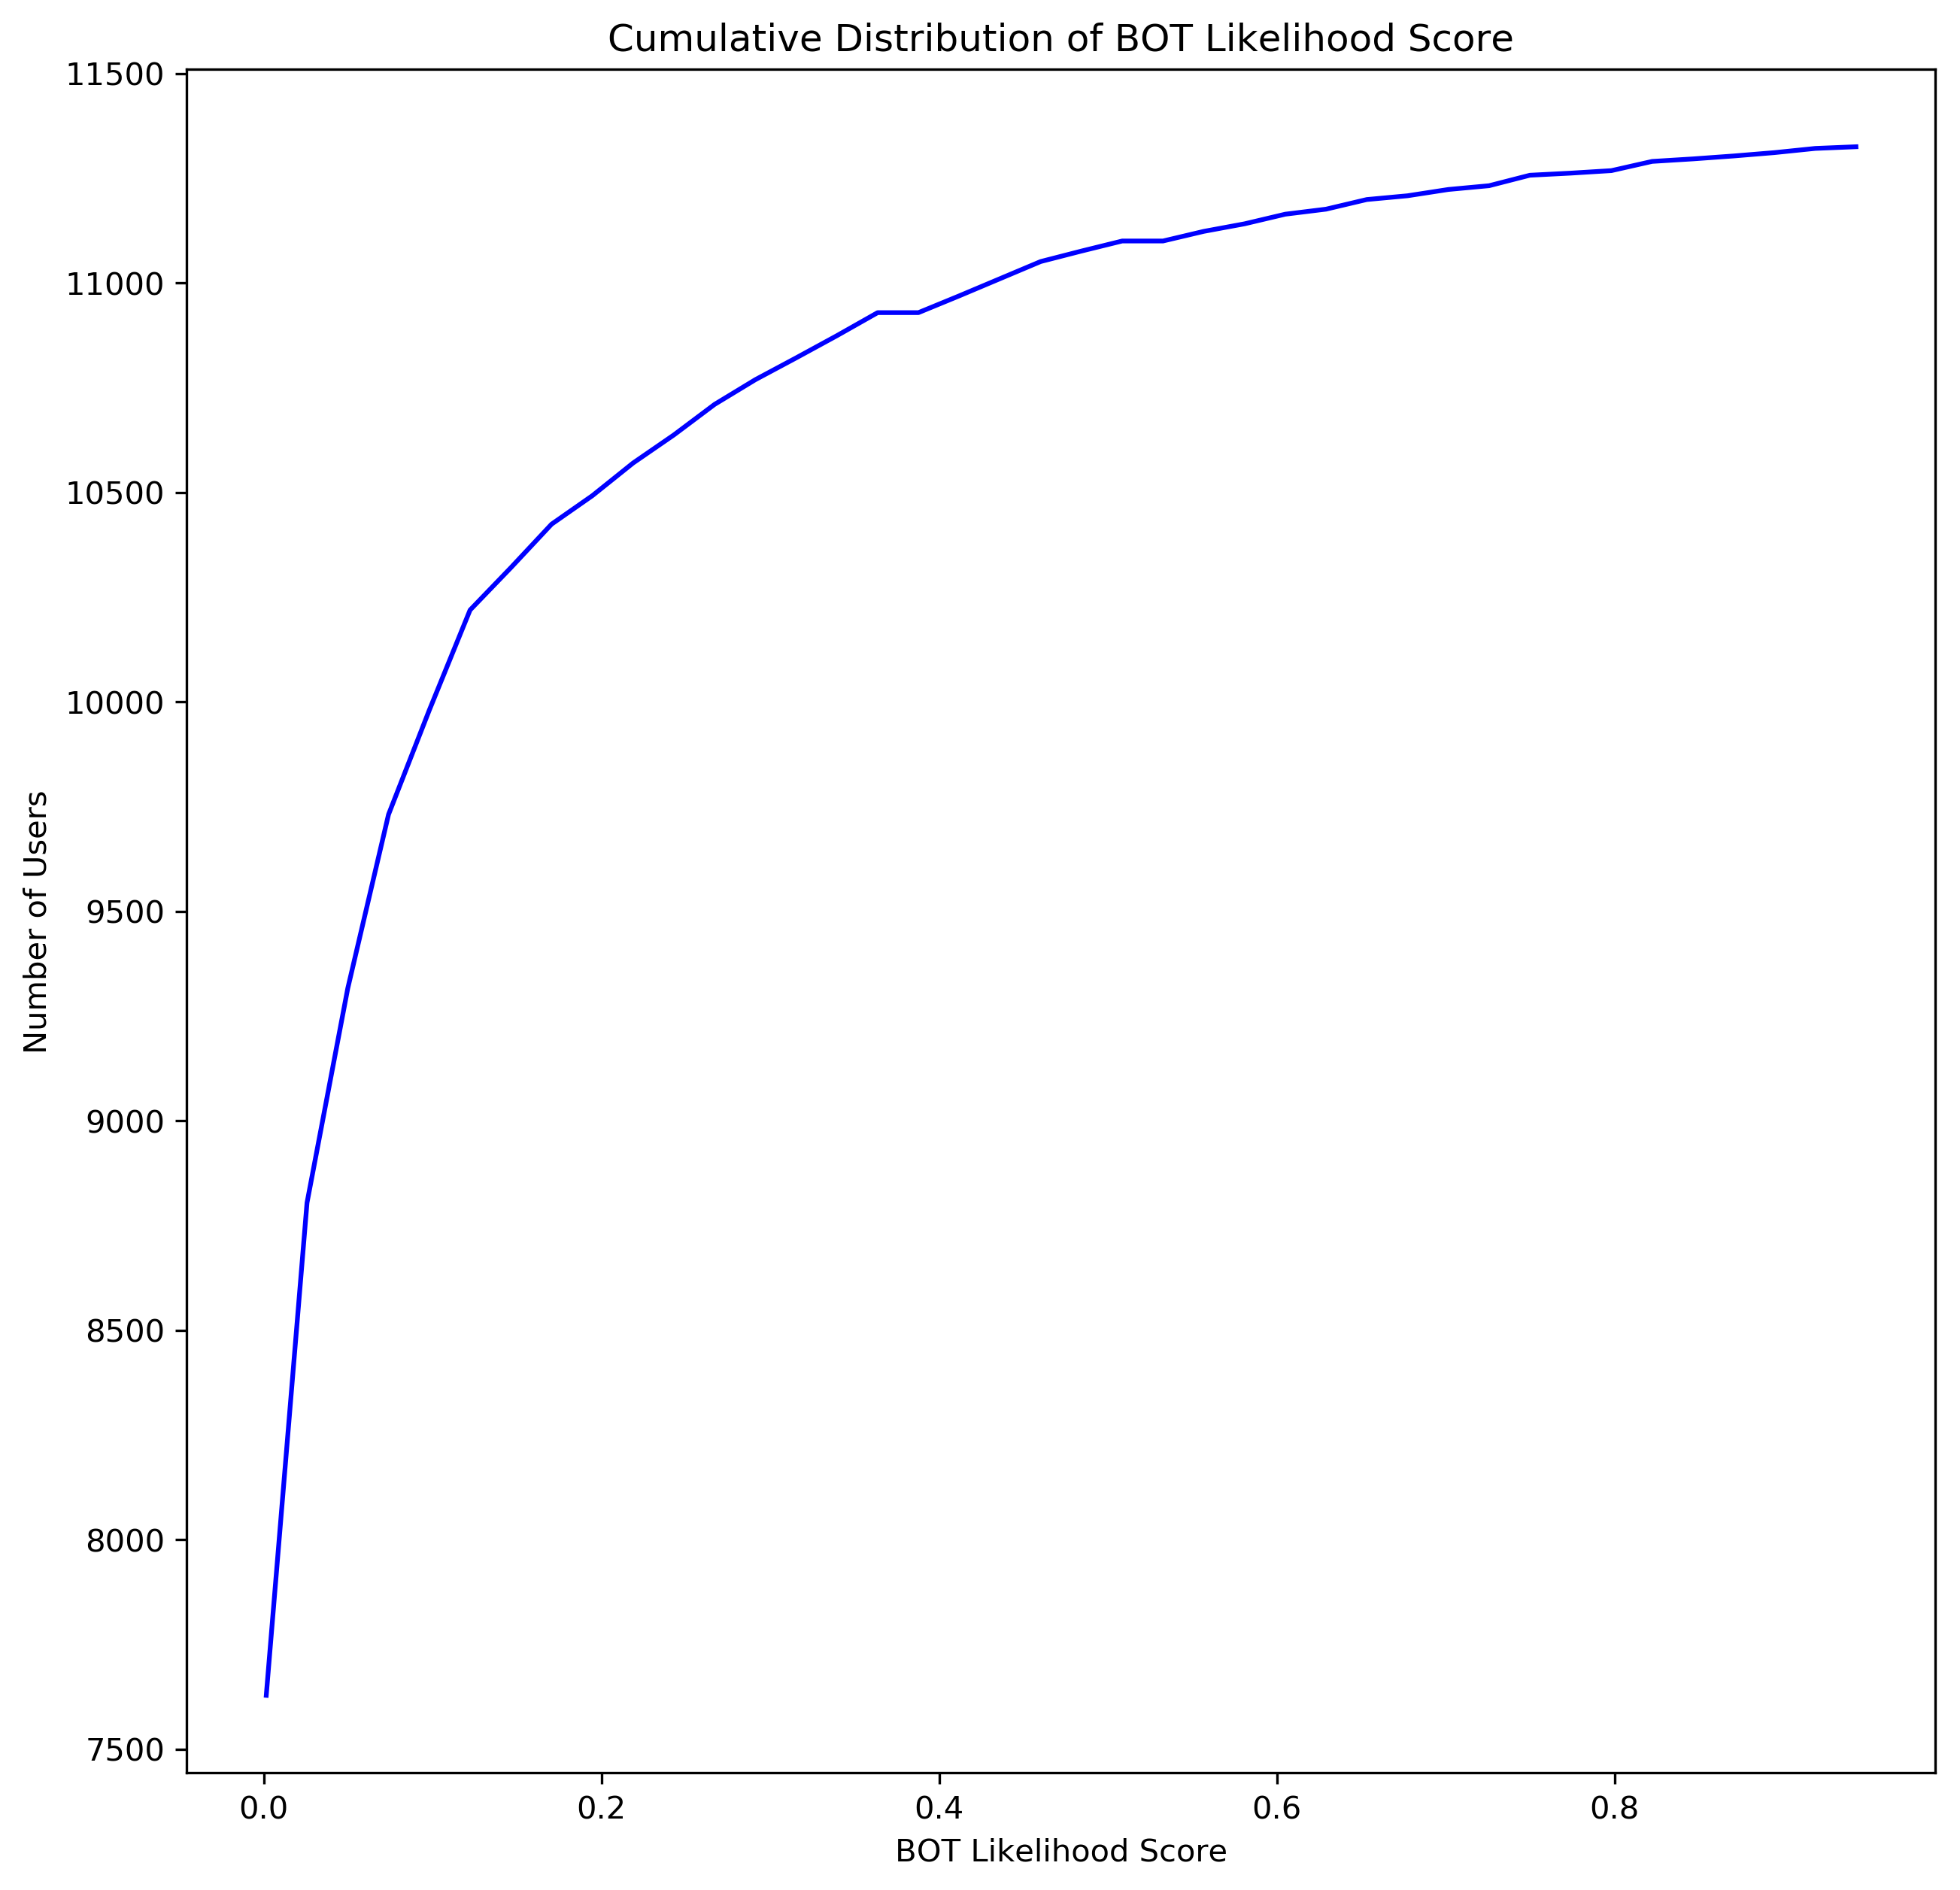

In [222]:
without_not_authorized = [float(i) for i in list(check_bot_dataframe['bot_score'])]
plot_cumulative(number_list=without_not_authorized, bin_num=40, color='blue', 
                title='Cumulative Distribution of BOT Likelihood Score', xlabel='BOT Likelihood Score', 
                ylabel='Number of Users', saving_path=bot_check_figure_path, 
                file_name='Cumulative_dist_bot_likelihood_score.png')

0.4 is a good cut-off value

In [148]:
check_bot_dataframe_copy = check_bot_dataframe.copy()
check_bot_dataframe_copy['bot_score'] = check_bot_dataframe_copy['bot_score'].astype('float')
bot_dataframe = check_bot_dataframe_copy.loc[check_bot_dataframe_copy['bot_score'] > 0.4]

In [154]:
bot_dataframe.shape

(396, 2)

In [165]:
botometer_bot_ids = list(bot_dataframe['account'])
# botometer_bot_ids

In [173]:
tweet_2016_2017_combined = pd.concat([tweet_2016_without_bot, tweet_2017_without_bot], axis=0)
tweet_2016_2017_combined.shape

(258330, 47)

In [171]:
tweet_2016_2017_final_filtered = tweet_2016_2017_combined.loc[~tweet_2016_2017_combined['user_id_str'].isin(botometer_bot_ids)]

In [172]:
tweet_2016_2017_final_filtered.shape

(250082, 47)

In [174]:
tweet_2016_2017_final_filtered.to_csv(os.path.join(bot_check_path, 'tweet_2016_2017_final_filtered.csv'), encoding='utf-8', 
                                     quoting=csv.QUOTE_NONNUMERIC)

In [176]:
tweet_2016_2017_final_filtered[['text', 'user_id_str']]

,text,user_id_str
12,#Working #Saturday #Afternoon! #Final #Touch i...,46583766
19,I'm at Hong Kong International Airport <U+9999...,60469721
32,Preparing for a photo shoot #glamourshots #bla...,854043475
37,I'm at Thai Basil in Admiralty https://t.co/LZ...,240570319
43,For #mothers or #kids ' #mother <U+263A><U+263...,76045582
45,<U+652F><U+6301><U+5C0F><U+5E97> (@ <U+661F><U...,805174
47,If you're a #Engineering professional in #Tsim...,51949191
51,yeah. LA DISNEY. lol @ <U+9999><U+6E2F><U+8FEA...,1901024592
49,Cheap hair cut (@ Scissor House) https://t.co/...,805174
58,Just posted a photo @ Mongkok- <U+65FA><U+89D2...,121710473


However, we notice that there are still some bots out there. For instance:

In [187]:
ads = tweet_2016_2017_final_filtered.loc[tweet_2016_2017_final_filtered['user_id_str'] == '51949191']

In [188]:
ads

,country,country_code,created_at,description,expanded_url,favorited,favourites_count,followers_count,friends_count,full_name,...,user_id_str,user_lang,user_url,utc_offset,verified,hk_time,year,month,month_plus_year,SmallTPU
47,<U+9999><U+6E2F>,HK,Sat May 07 07:09:11 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/1TqL7EO,FALSE,0,638,495,"Yau Tsim Mong District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-07 15:09:11+08:00,2016,5,2016_5,212
147,<U+9999><U+6E2F>,HK,Sat May 07 07:23:07 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/1pxYnLo,FALSE,0,637,495,"Kowloon City District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-07 15:23:07+08:00,2016,5,2016_5,234
47,<U+9999><U+6E2F>,HK,Sun May 08 01:20:21 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/1SAs5uG,FALSE,0,631,495,"Kowloon City District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-08 09:20:21+08:00,2016,5,2016_5,234
126,<U+9999><U+6E2F>,HK,Sun May 08 01:48:26 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/20ow7Yf,FALSE,0,631,495,"Kowloon City District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-08 09:48:26+08:00,2016,5,2016_5,234
55,<U+9999><U+6E2F>,HK,Sun May 08 02:16:25 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/1RMcngj,FALSE,0,631,495,"Kowloon City District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-08 10:16:25+08:00,2016,5,2016_5,234
94,<U+9999><U+6E2F>,HK,Sun May 08 02:30:24 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/1TTO94w,FALSE,0,631,495,"Tsuen Wan District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-08 10:30:24+08:00,2016,5,2016_5,"331-334, 336 & 340"
158,<U+9999><U+6E2F>,HK,Sun May 08 02:44:19 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/1QSFUQ9,FALSE,0,630,495,"Wan Chai District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-08 10:44:19+08:00,2016,5,2016_5,133
235,<U+9999><U+6E2F>,HK,Sun May 08 02:58:15 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/1YIa1yO,FALSE,0,630,495,"Eastern District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-08 10:58:15+08:00,2016,5,2016_5,151
35,<U+9999><U+6E2F>,HK,Sun May 08 03:12:10 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/1TYHeWT,FALSE,0,630,495,"Tsuen Wan District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-08 11:12:10+08:00,2016,5,2016_5,"331-334, 336 & 340"
100,<U+9999><U+6E2F>,HK,Sun May 08 03:26:05 +0000 2016,Follow this account for geo-targeted Other job...,http://bit.ly/20M2ccs,FALSE,0,630,495,"Wan Chai District, Hong Kong",...,51949191,en,http://www.careerarc.com/job-seeker,-14400,FALSE,2016-05-08 11:26:05+08:00,2016,5,2016_5,133


We then set the prop_threshold = 0.6 and filter the dataframe again

In [189]:
final_dataframe = delete_bots_have_same_geoinformation(tweet_2016_2017_final_filtered, prop_threshold=0.6)

Done!


In [191]:
number_of_tweet_user(final_dataframe)

Total number of tweet is: 241123; Total number of user is 12109


In [192]:
final_dataframe.to_csv(os.path.join(bot_check_path, 'tweet_2016_2017_final_filtered.csv'), encoding='utf-8', 
                      quoting=csv.QUOTE_NONNUMERIC)

In [193]:
list(final_dataframe['text'])

['#Working #Saturday #Afternoon! #Final #Touch is on the #way! #Excited! #JerryMaguire #Dessert?https://t.co/q4GWk8nZFm',
 'Preparing for a photo shoot #glamourshots #blackandwhitephotohraphy #blackandwhite #beauty?https://t.co/PEVkAoleNQ',
 "I'm at Thai Basil in Admiralty https://t.co/LZOfrTCq5W",
 "For #mothers or #kids ' #mother <U+263A><U+263A><U+263A> \r\r\n#mothersday #<U+6BCD><U+89AA><U+7BC0> #<U+30D9><U+30A2><U+30D6><U+30EA><U+30C3><U+30AF> #<U+30D9><U+30A2><U+90E8> #<U+BCA0><U+C5B4><U+BE0C><U+B9AD> #medicomtoy #medicom?https://t.co/TCRjDS0b7c",
 '<U+652F><U+6301><U+5C0F><U+5E97> (@ <U+661F><U+532F><U+6252><U+5C4B>) https://t.co/SmvbXpWz1Z https://t.co/R5RQZFSW5H',
 'yeah. LA DISNEY. lol @ <U+9999><U+6E2F><U+8FEA><U+58EB><U+5C3C><U+6A02><U+5712> Disneyland Hk https://t.co/ZAzarwc5f6',
 'Cheap hair cut (@ Scissor House) https://t.co/XzzUajbs5C',
 'Just posted a photo @ Mongkok- <U+65FA><U+89D2>, Hongkong https://t.co/bokpUZJU4R',
 'Captain and Team Manager awaiting the bus for f

In [216]:
number_of_tweet_user(final_dataframe)

Total number of tweet is: 241123; Total number of user is 12109


## 8. The Summary of the Final Filtered Dataset

In this part, we should work out the general information of these two pandas dataframe ```final_dataframe``` and ```total_dataframe```. We could consider the following aspects:

1. Language
2. Percentage of Geocoded Tweets
3. Number of tweets posted by users

In [249]:
number_of_tweet_user(final_dataframe)

Total number of tweet is: 241123; Total number of user is 12109


In [250]:
number_of_tweet_user(total_dataframe)

Total number of tweet is: 2883908; Total number of user is 179022


In [256]:
Counter(final_dataframe['lang'])

Counter({'en': 177497, 'zh': 63626})

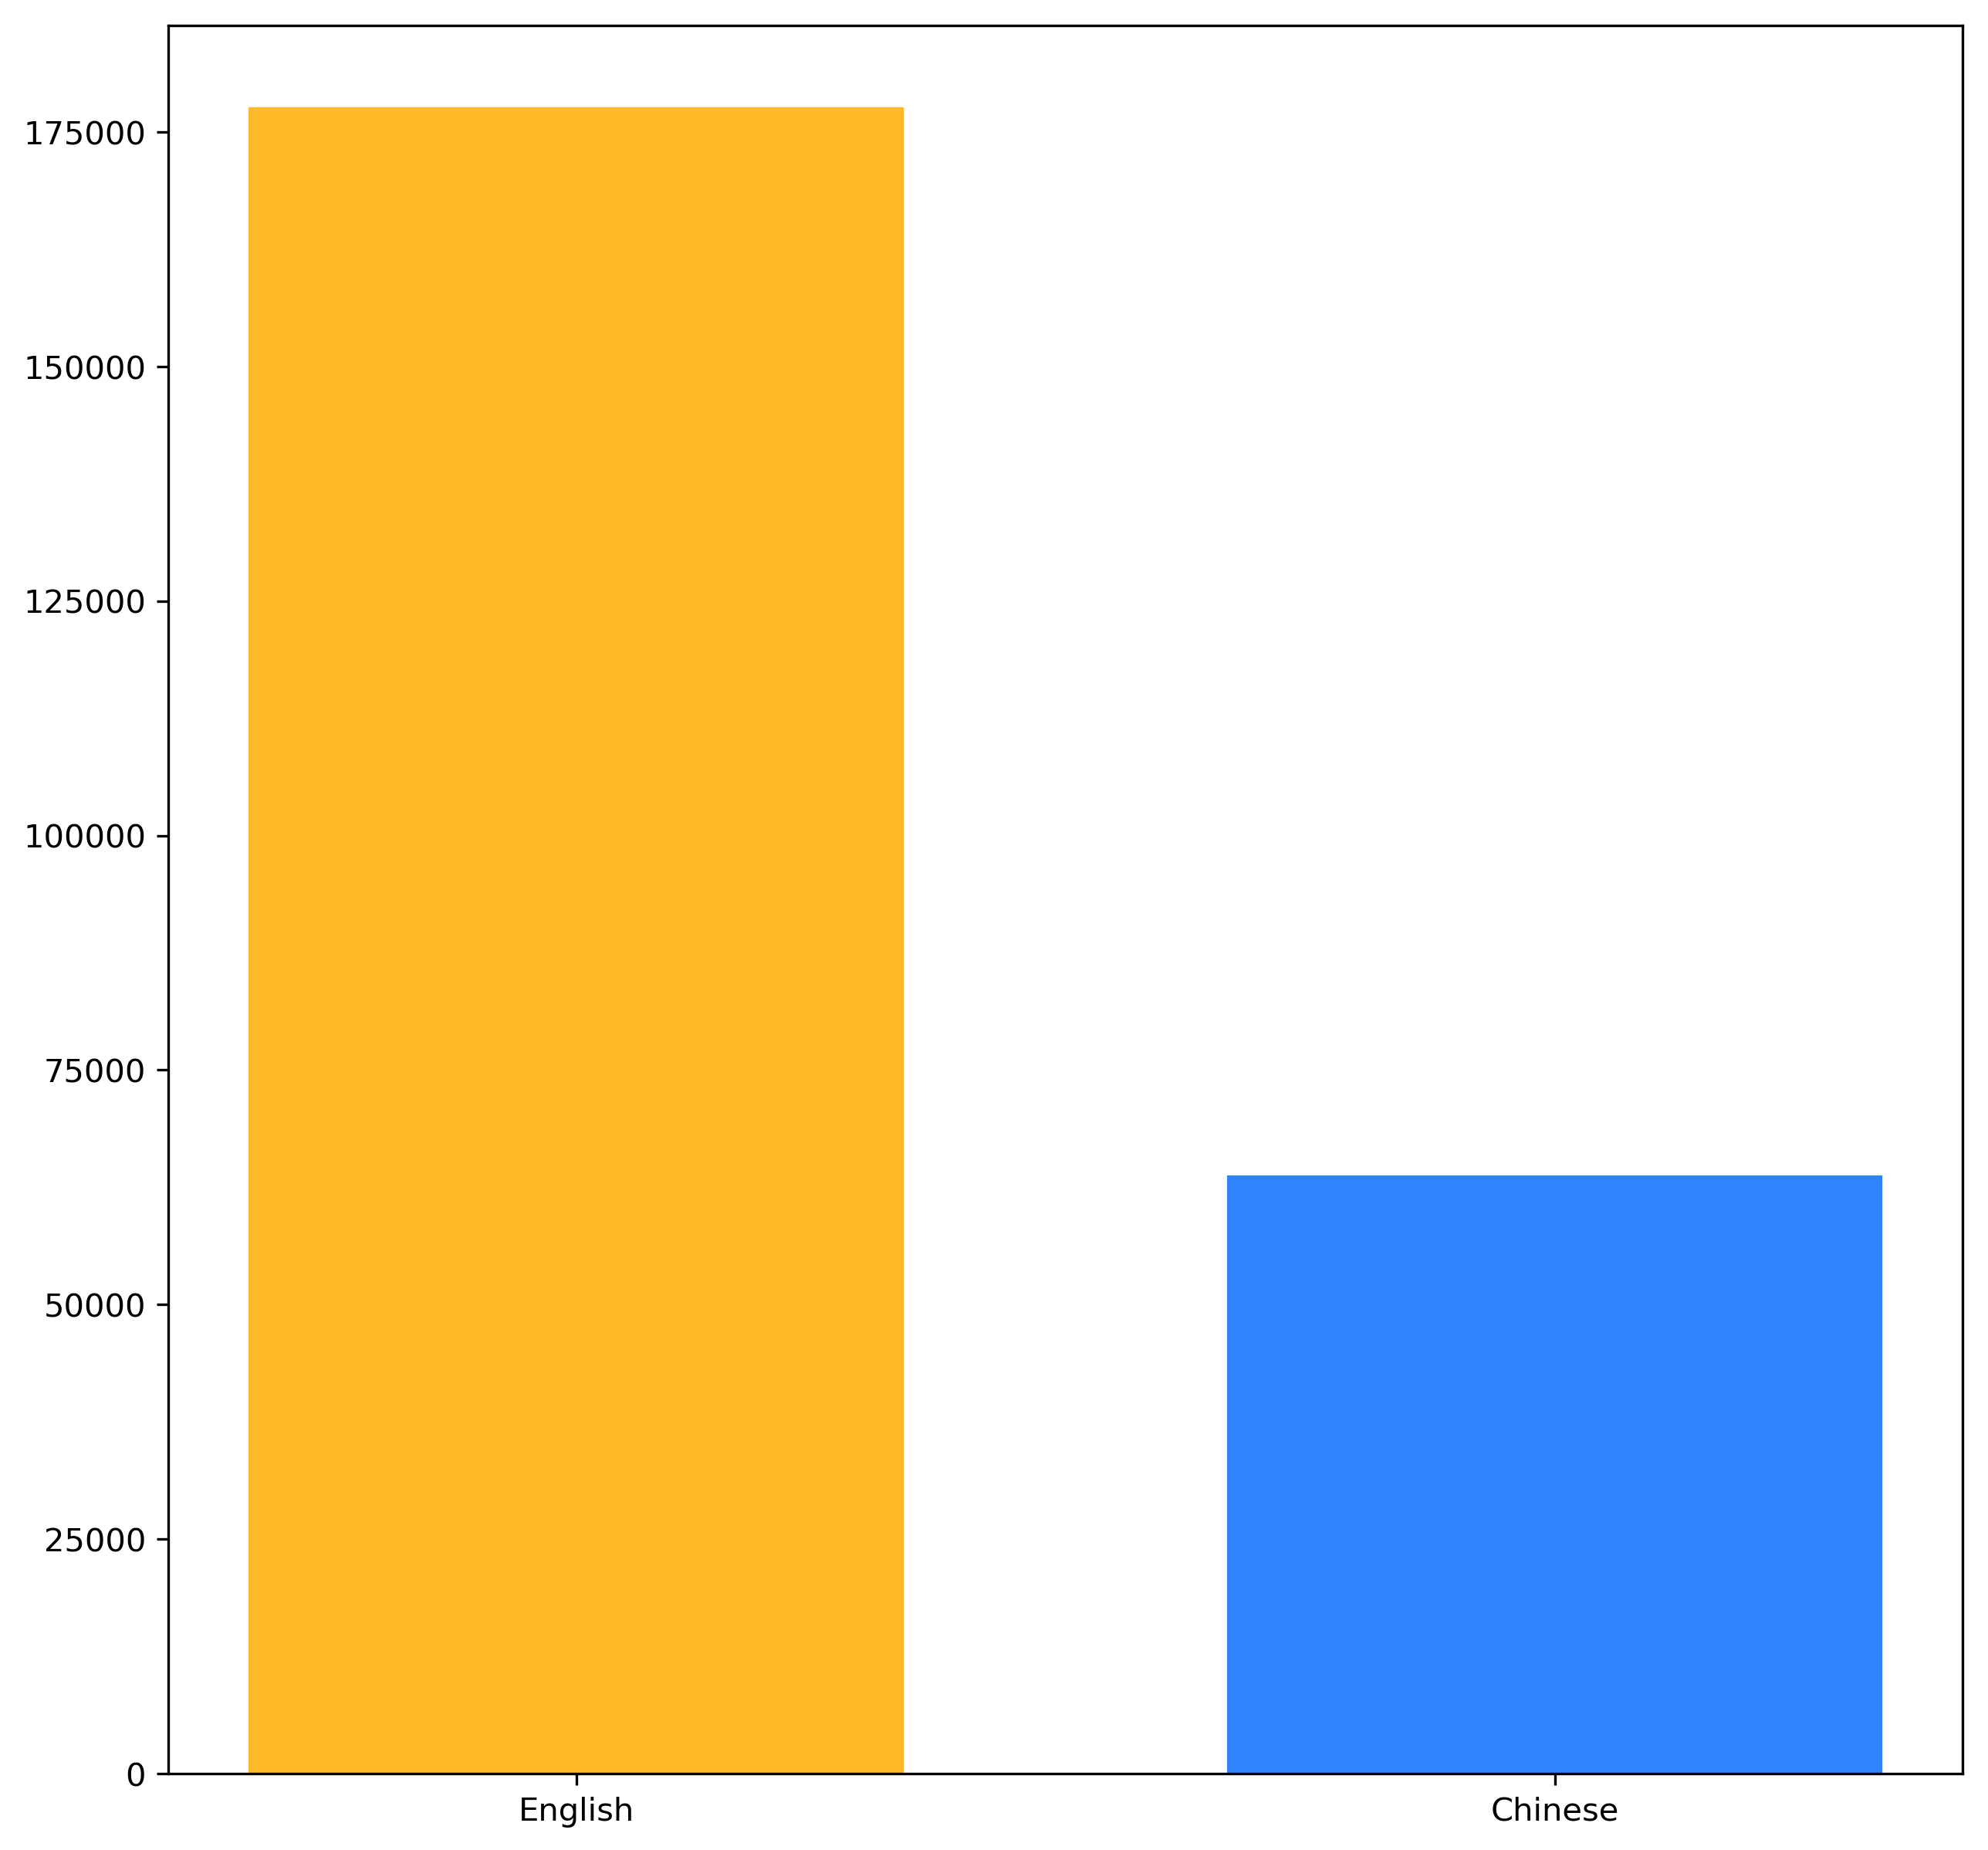

In [263]:
fig, axes = plt.subplots(1,1,figsize=(10, 10), dpi=300)
x = ['English', 'Chinese']
y = [177497, 63626]
barlist = axes.bar(x, y, width=1/1.5)
barlist[0].set_color('#FFB828')
barlist[1].set_color('#3083FF')
fig.savefig(os.path.join(desktop, 'lang_distrib.png'))
plt.show()

In [264]:
filtered_tweet_num_geo_prop_list = compute_tweet_num_geo_prop(final_dataframe)
print(filtered_tweet_num_geo_prop_list[:5])

[(2, 0.5), (3, 0.3333333333333333), (2, 0.5), (23, 0.08695652173913043), (2, 0.5)]


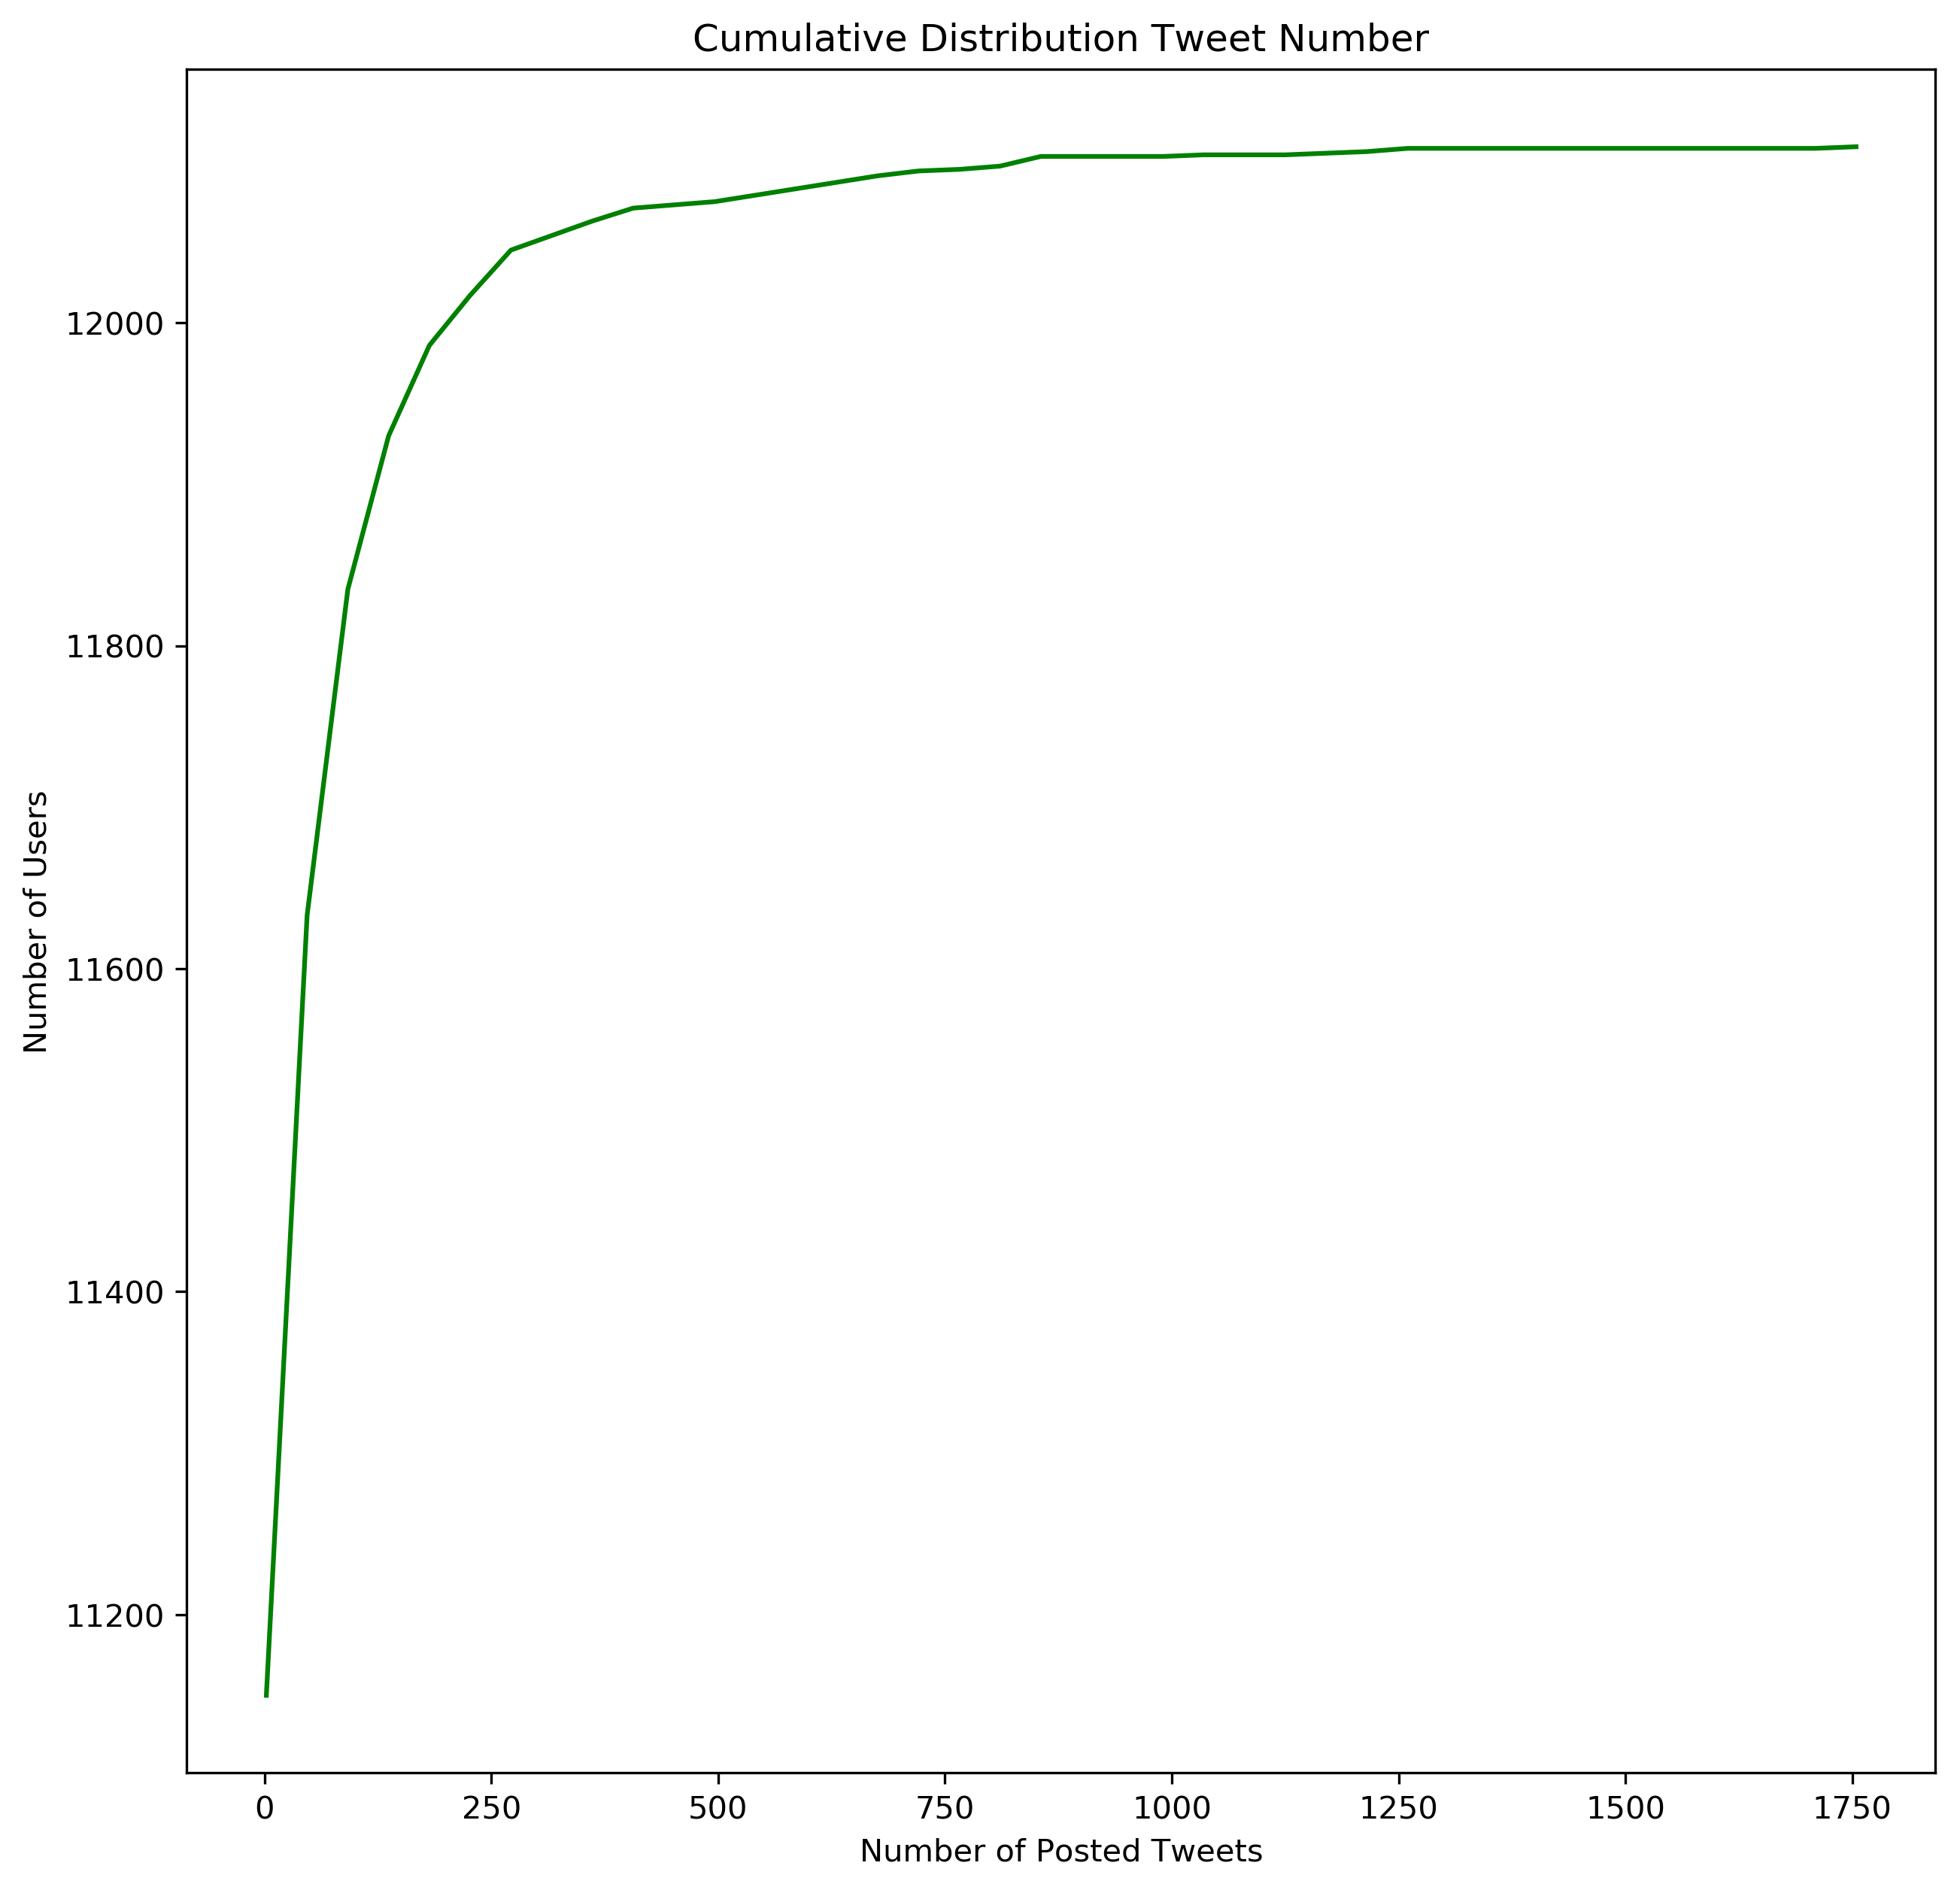

In [265]:
filtered_tweet_num_list = [value[0] for value in filtered_tweet_num_geo_prop_list]
plot_cumulative(number_list=filtered_tweet_num_list, bin_num=40, color='green', title='Cumulative Distribution Tweet Number', 
                xlabel='Number of Posted Tweets', ylabel='Number of Users', saving_path=bot_check_figure_path, 
                file_name='Cumulative_dist_filtered_tweet_num.png')